In [1]:
from IPython.display import clear_output
clear_output()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import os

In [2]:
# load dataset
df = pd.read_excel('RTW DATA.xlsx')


def clean_data(df):
    # Drop duplicate rows across all columns
    df = df.drop_duplicates()
    # Filter rows based on column: 'LNCStatus'
    df = df[df['LNCStatus'] != "DRAFT"]

    # Derive column 'isNC' from column: 'LNCNo'
    def isNC(LNCNo):
        if pd.isnull(LNCNo) or not str(LNCNo):
            return 0
        # Jika LNCNo mengandung "-", anggap sebagai NC (1)
        if "-" in str(LNCNo):
            return 1
        return 0

    df["isNC"] = df["LNCNo"].apply(isNC)

    # Replace gaps forward from the previous valid value in: 'TimeStop'
    df = df.fillna({'TimeStop': df['TimeStop'].ffill()})
    # Replace missing values with the most common value of each column in: 'Product'
    df = df.fillna({'Product': df['Product'].mode()[0]})
    # Replace missing values with "unknown" in column: 'LNCNo'
    df = df.fillna({'LNCNo': "unknown"})
    # Replace missing values with 0 in column: 'Plant'
    df = df.fillna({'Plant': 0})
    # Replace missing values with "unknown" in column: 'Department'
    df = df.fillna({'Department': "unknown"})
    # Replace missing values with "unknown" in column: 'WorkCenter'
    df = df.fillna({'WorkCenter': "unknown"})
    # Replace missing values with "unknown" in columns: 'FGCode', 'LotNo', 'ProductionDate'
    df = df.fillna({'FGCode': "unknown", 'LotNo': "unknown", 'ProductionDate': "unknown"})
    # Replace missing values with 0 in column: 'Shift'
    df = df.fillna({'Shift': 0})
    # Replace missing values with 0 in column: 'QtyOutput3'
    df = df.fillna({'QtyOutput3': 0})
    # Replace missing values with "unknown" in column: 'LeaderName'
    df = df.fillna({'LeaderName': "unknown"})
    # Drop columns: 'DraftDate', 'RejectReason' and 3 other columns
    df = df.drop(columns=['DraftDate', 'RejectReason', 'ProcessAssy', 'EquipmentID', 'FormInput'])
    # Change column type to string for columns: 'CreateUser', 'ApproveBy' and 2 other columns
    df = df.astype({'CreateUser': 'string', 'ApproveBy': 'string', 'Shift': 'string', 'Plant': 'string'})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,SessionID,TimeStart,TimeStop,ProcessBy,ShiftID,Product,WeightID,Location,LeaderID,Mpw,...,ProductionDate,Shift,QtyOutput3,LeaderName,LNCStatus,ApproveBy,ApproveDate,CreateDate,CreateUser,isNC
1,BCLH000380,2025-08-05 23:35:47.543,2025-08-05 23:47:42.003,230302,3,ST,WMSL01,SL01,ELSE,11,...,2025-08-05,1.0,240.0,YUSUF,COMPLETED,220596.0,2025-08-05 17:14:06.693,2025-08-05 17:14:06.693,220596.0,1
2,BCLH000169,2025-08-05 11:21:39.053,2025-08-05 12:02:15.893,920395,1,ST,WMJK01,SL01,YUSUF,2,...,2025-08-04,1.0,960.0,YUSUF,COMPLETED,220596.0,2025-08-04 17:13:54.677,2025-08-04 17:13:54.677,220596.0,1
3,BCLG002388,2025-08-01 10:03:30.380,2025-08-01 10:13:43.553,920395,1,ST,WMJK01,SL01,ELSE,2,...,2025-08-01,1.0,960.0,ELSE,COMPLETED,220596.0,2025-08-02 06:53:20.893,2025-08-02 06:53:20.893,220596.0,1
4,BCLH000018,2025-08-04 16:12:00.200,2025-08-04 16:31:53.787,920395,1,ST,WMJK01,SL06,YUDA,2,...,2025-08-01,1.0,540.0,YUDA,COMPLETED,220534.0,2025-08-01 16:14:58.287,2025-08-01 16:14:58.280,220534.0,1
5,BCLG002412,2025-08-04 11:32:03.930,2025-08-04 11:42:32.303,920395,1,ST,WMJK01,SL01,YUSUF,2,...,2025-07-31,1.0,960.0,YUSUF,COMPLETED,220596.0,2025-08-01 06:46:09.520,2025-08-01 06:46:09.520,220596.0,1


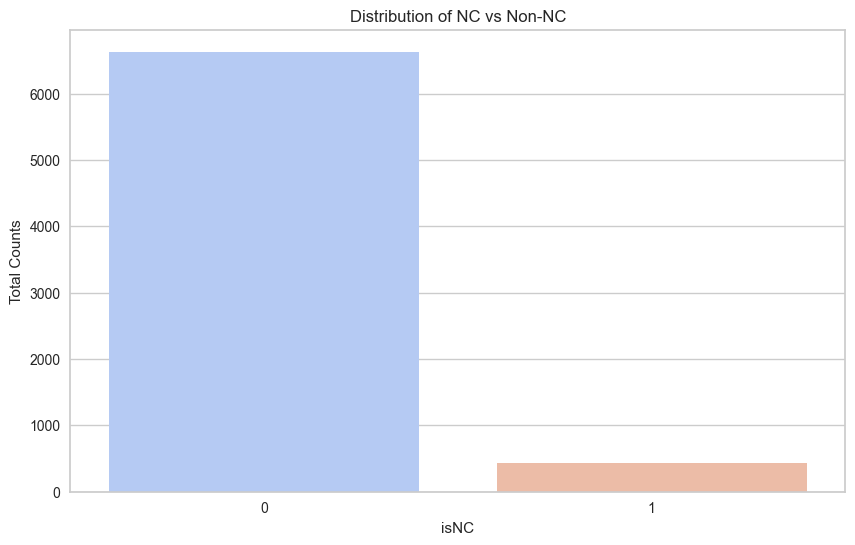

In [3]:
# Plot the distribution of 'isNC' column
plt.figure(figsize=(10,6))
sns.countplot(x='isNC', data=df_clean, palette='coolwarm')
plt.title('Distribution of NC vs Non-NC')
plt.xlabel('isNC')
plt.ylabel('Total Counts')
plt.show()

In [4]:
# split data into feature and target
X = df_clean.drop(columns=['isNC'])
y = df_clean['isNC']


# apply random oversampling to handle imbalance
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X,y)

In [5]:
# Combine back into a single DataFrame
data_ros = pd.DataFrame(X_ros, columns=X.columns)
data_ros['isNC'] = y_ros

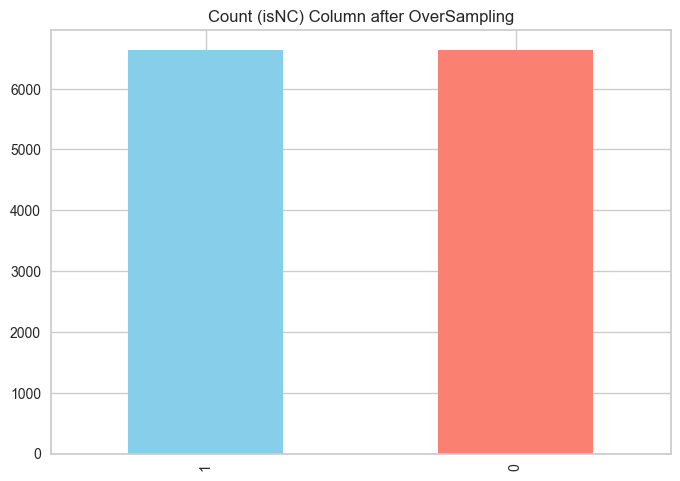

In [6]:
pd.Series(y_ros).value_counts().plot(kind='bar', title='Count (isNC) Column after OverSampling', color=['skyblue', 'salmon'])
plt.show()

In [7]:
print(data_ros.dtypes)

SessionID          object
TimeStart          object
TimeStop           object
ProcessBy          object
ShiftID            object
Product            object
WeightID           object
Location           object
LeaderID           object
Mpw                 int64
ProdCode           object
Lot                object
QtyOutput           int64
Remark             object
LNCNo              object
Plant              string
Department         object
WorkCenter         object
SessionID2         object
FGCode             object
LotNo              object
ProductionDate     object
Shift              string
QtyOutput3        float64
LeaderName         object
LNCStatus          object
ApproveBy          string
ApproveDate        object
CreateDate         object
CreateUser         string
isNC                int64
dtype: object


In [ ]:
df_clean

In [13]:
# Set up PyCaret environment with Random Oversampled data
clf = setup(
    data=df_clean,
    target='isNC',
    session_id=42,
    fix_imbalance=True, 
    normalize=True,
    remove_outliers=True,
    outliers_threshold=0.05,
)

AttributeError: 'bool' object has no attribute 'transpose'